In [14]:
#load in all data
import numpy as np
def split_by_week(df, n):
    min_week = df["WEEK_NUM"].min()
    max_week = df["WEEK_NUM"].max()
    bins = np.linspace(min_week, max_week + 1, n + 1, dtype=int)

    segments = {}
    for i in range(n):
        lower = bins[i]
        upper = bins[i + 1]
        key = f"split_{i}"
        segment = df[(df["WEEK_NUM"] >= lower) & (df["WEEK_NUM"] < upper)].copy()
        segments[key] = segment.sort_values(by=["WEEK_NUM"])

    return segments

top_100 = [
 'avgdpdtolclosure24_3658938P', 'dateofcredstart_739D_days_from_decision', 'dpdmax_139P',
 'pmtnum_254L', 'numberofoverdueinstlmax_1039L', 'price_1097A', 'age_at_decision', 'sex_738L',
 'mobilephncnt_593L', 'overdueamountmax_155A', 'numrejects9m_859L', 'numberofcontrsvalue_358L',
 'pmtssum_45A', 'incometype_1044T', 'amount_4527230A', 'education_927M', 'days120_123L',
 'pmtaverage_3A', 'numinstlswithdpd10_728L', 'cntpmts24_3658933L', 'dpdmaxdateyear_596T',
 'firstclxcampaign_1125D_days_from_decision', 'totaldebtoverduevalue_178A', 'pmtscount_423L',
 'annuity_780A', 'isbidproduct_1095L', 'residualamount_856A', 'pctinstlsallpaidlate1d_3546856L',
 'credamount_770A', 'eir_270L', 'totalamount_996A', 'numinstpaidearly3d_3546850L', 'dpdmax_757P',
 'days90_310L', 'days30_165L', 'dateofbirth_337D_days_from_decision', 'days180_256L',
 'numinsttopaygr_769L', 'maxdbddpdtollast12m_3658940P', 'pctinstlsallpaidearl3d_427L',
 'validfrom_1069D_days_from_decision', 'currdebt_22A', 'interestrate_311L', 'overdueamountmax2_14A',
 'familystate_447L', 'birthdate_574D_days_from_decision', 'empl_employedfrom_271D_days_from_decision',
 'applicationscnt_867L', 'totaldebt_9A', 'disbursedcredamount_1113A', 'maxdpdlast24m_143P',
 'totaloutstanddebtvalue_39A', 'dateofcredstart_181D_days_from_decision', 'lastrejectcredamount_222A',
 'maxdpdlast3m_392P', 'maxdpdlast9m_1059P', 'avgdbddpdlast24m_3658932P', 'language1_981M',
 'credtype_322L', 'totalamount_6A', 'inittransactionamount_650A', 'approvaldate_319D_days_from_decision',
 'lastdelinqdate_224D_days_from_decision', 'pmtnum_8L', 'days360_512L', 'numberofoverdueinstlmax_1151L',
 'lastrejectreasonclient_4145040M', 'numinstlallpaidearly3d_817L',
 'lastrejectdate_50D_days_from_decision', 'maxdpdlast12m_727P', 'homephncnt_628L',
 'education_1138M', 'education_1103M', 'debtoutstand_525A', 'totalsettled_863A',
 'numinstunpaidmax_3546851L', 'lastrejectreason_759M', 'pmtaverage_4527227A', 'overdueamountmax_35A',
 'monthsannuity_845L', 'maxannuity_159A', 'maxdbddpdlast1m_3658939P', 'maxdpdlast6m_474P',
 'responsedate_4527233D_days_from_decision', 'instlamount_768A', 'dtlastpmt_581D_days_from_decision',
 'numinstlsallpaid_934L', 'tenor_203L', 'maxdpdtolerance_577P', 'numinstunpaidmaxest_4493212L',
 'numberofoverdueinstlmaxdat_641D_days_from_decision', 'familystate_726L', 'maxdpdtolerance_374P',
 'numinstlswithoutdpd_562L', 'disbursementtype_67L', 'lastst_736L', 'numinstlswithdpd5_4187116L',
 'cntincpaycont9m_3716944L', 'requesttype_4525192L', 'avgdbddpdlast3m_4187120P'
]

import pandas as pd
df = pd.read_parquet("/rds/general/user/ms2524/home/MSc-project/notebooks/oldmerged.parquet", columns = top_100 + ["WEEK_NUM", "target", "case_id"])
for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].astype('category')
features_with_missing = [col for col in df.columns if df[col].isna().any()]

def add_flag(df, threshold=0.05):
    df = df.copy()
    missing = df.isna().mean() 
    cols = missing[missing> threshold].index.tolist()
    for col in cols:
        df[col + '_missing'] = df[col].isna().astype(int)
    return df

def encode_features(df, categorical_features):
    df = df.copy()
    df = pd.get_dummies(df, columns=categorical_features, drop_first=True)
    return df
df = encode_features(df, df.select_dtypes(include=['object', 'category']).columns.tolist())
df = add_flag(df)

def impute_features(train_df, test_df, features, sentinel=-99999):

    train_df = train_df.copy()
    test_df = test_df.copy()

    for feature in features:
        is_int_feature = (
            pd.api.types.is_integer_dtype(train_df[feature].dtype) or
            pd.api.types.is_integer_dtype(test_df[feature].dtype)
        )

        valid_train_vals = train_df[feature][(train_df[feature].notna())]
        median_val = valid_train_vals.median() if not valid_train_vals.empty else None

        if median_val is not None and is_int_feature:
            median_val = int(round(median_val))

        if is_int_feature:
            train_df[feature] = train_df[feature].astype("Int32")
            test_df[feature] = test_df[feature].astype("Int32")
        else:
            train_df[feature] = train_df[feature].where(train_df[feature].notna(), np.nan).astype(float)
            test_df[feature] = test_df[feature].where(test_df[feature].notna(), np.nan).astype(float)

        if median_val is not None:
            train_df[feature] = train_df[feature].fillna(median_val)
            test_df[feature] = test_df[feature].fillna(median_val)
        else:
            train_df[feature] = train_df[feature].fillna(sentinel)
            test_df[feature] = test_df[feature].fillna(sentinel)

    return train_df, test_df
final_segments = split_by_week(df,30)

# Preliminary analysis of drift

In [15]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss, log_loss

def drift(
    final_segments,
    random_state=42
):
    exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
    features = [c for c in final_segments['split_0'].columns if c not in exclude_cols]
    sorted_keys = sorted(final_segments.keys(), key=lambda k: int(k.split('_')[-1]))

    X_splits = [final_segments[k][features] for k in sorted_keys]
    y_splits = [final_segments[k]['target'].to_numpy() for k in sorted_keys]

    X_train_raw = X_splits[0]
    y_train = y_splits[0]
    X_train_imp, _ = impute_features(X_train_raw, X_train_raw, features_with_missing)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_imp.to_numpy())

    model = LogisticRegression(max_iter=1000, random_state=random_state, penalty=None)
    model.fit(X_train_scaled, y_train)

    results = []
    for t in range(1, len(sorted_keys)):
        key = sorted_keys[t]
        X_test_raw = X_splits[t]
        y_test = y_splits[t]

        _, X_test_imp = impute_features(X_train_raw, X_test_raw, features_with_missing)
        X_test_scaled = scaler.transform(X_test_imp.to_numpy())

        y_proba = model.predict_proba(X_test_scaled)[:, 1]

        n = len(y_proba)
        pred_mean = y_proba.mean()
        pred_std = y_proba.std(ddof=1) 
        pred_se = pred_std / np.sqrt(n)

        results.append({
            "segment_num": int(key.split("_")[1]),
            "actual_default_rate": y_test.mean(),
            "predicted_default_rate": pred_mean,
            "predicted_default_rate_se": pred_se,
        })

    return pd.DataFrame(results)


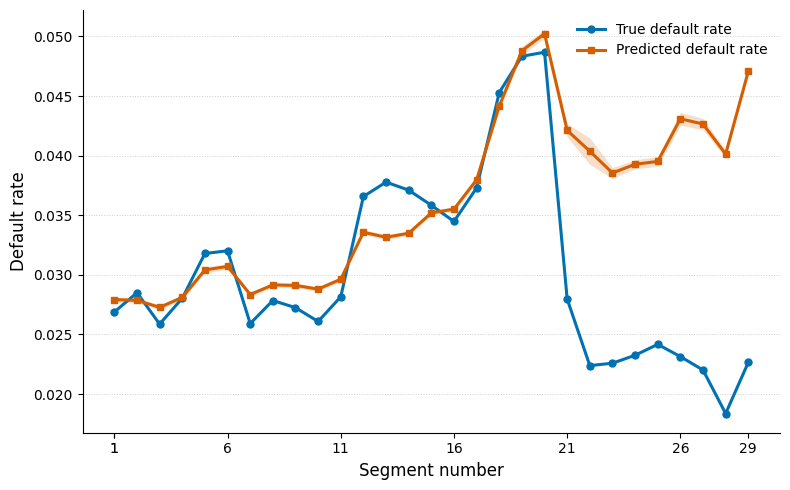

In [16]:
import matplotlib.pyplot as plt

res = drift(final_segments)
res_sorted = res.sort_values("segment_num")
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(
    res_sorted["segment_num"], res_sorted["actual_default_rate"],
    marker="o", markersize=5, lw=2.2, color="#0072B2", label="True default rate"
)

x = res_sorted["segment_num"]
m = res_sorted["predicted_default_rate"]
se = res_sorted["predicted_default_rate_se"]

ax.plot(
    x, m,
    marker="s", markersize=5, lw=2.2, color="#D55E00", label="Predicted default rate"
)

ax.fill_between(
    x, m - se, m + se,
    color="#D55E00", alpha=0.2, linewidth=0
)

ax.set_xlabel("Segment number", fontsize=12)
ax.set_ylabel("Default rate", fontsize=12)
ax.set_xticks([1, 29] + list(np.arange(1, 30, 5)))
ax.grid(axis="y", linestyle=":", linewidth=0.7, alpha=0.6)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.legend(frameon=False)

plt.tight_layout()
plt.savefig("drift.pdf", format="pdf", bbox_inches="tight")
plt.show()


# Partial feedback plot

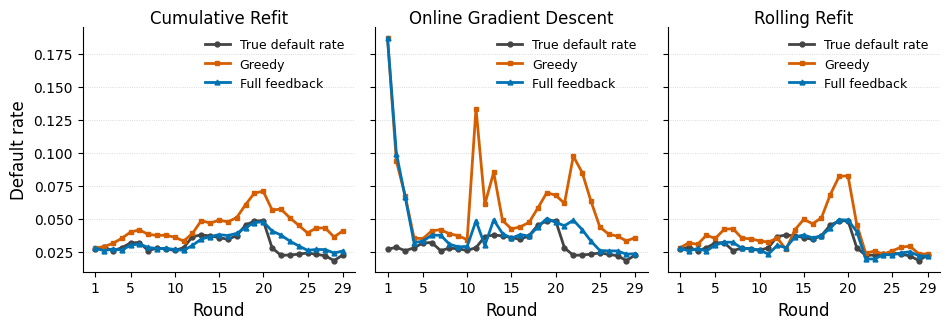

In [38]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load(pattern, sort_col, value_col):
    files = glob.glob(pattern)
    df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
    out = df.groupby(sort_col)[[value_col]].agg(['mean','std']).reset_index()
    out.columns = [sort_col, f"{value_col}_mean", f"{value_col}_std"]
    return out.sort_values(sort_col)

path = "/rds/general/user/ms2524/home/MSc-project/notebooks/666"

models = {
    "Cumulative Refit": {
        "bandit": f"{path}/cf_bandit_seed*.csv",
        "oracle": f"{path}/cf_oracle_seed*.csv",
    },
    "Online Gradient Descent": {
        "bandit": f"{path}/ogd_bandit_seed*.csv",
        "oracle": f"{path}/ogd_oracle_seed*.csv",
    },
    "Rolling Refit": {
        "bandit": f"{path}/rf_bandit_seed*.csv",
        "oracle": f"{path}/rf_oracle_seed*.csv",
    },
}

fig, axes = plt.subplots(1, 3, figsize=(9.6, 3.4), sharey=True)
labels = ["Cumulative Refit", "Online Gradient Descent", "Rolling Refit"]

for ax, (name, paths), lab in zip(axes, models.items(), labels):
    bandit = load(paths["bandit"], "segment_num", "predicted_default_rate")
    oracle = load(paths["oracle"], "segment_num", "predicted_default_rate")
    true = pd.read_csv(glob.glob(paths["bandit"])[0]).sort_values("segment_num")

    ax.plot(true["segment_num"], true["actual_default_rate"], lw=2.0, marker="o", ms=3.5, color="#444444", label="True default rate")
    ax.plot(bandit["segment_num"], bandit["predicted_default_rate_mean"], lw=2.0, marker="s", ms=3.5, color="#D55E00", label="Greedy")
    ax.plot(oracle["segment_num"], oracle["predicted_default_rate_mean"], lw=2.0, marker="^", ms=3.5, color="#0072B2", label="Full feedback")

    ax.fill_between(
        bandit["segment_num"],
        bandit["predicted_default_rate_mean"] - bandit["predicted_default_rate_std"],
        bandit["predicted_default_rate_mean"] + bandit["predicted_default_rate_std"],
        alpha=0.18, color="#D55E00", linewidth=0
    )
    ax.fill_between(
        oracle["segment_num"],
        oracle["predicted_default_rate_mean"] - oracle["predicted_default_rate_std"],
        oracle["predicted_default_rate_mean"] + oracle["predicted_default_rate_std"],
        alpha=0.18, color="#0072B2", linewidth=0
    )

    ax.set_xlabel("Round", fontsize=12)
    ax.set_title(lab, loc="center", fontsize=12, pad=2)
    ax.grid(axis="y", linestyle=":", linewidth=0.6, alpha=0.6)
    xmin = true["segment_num"].min()
    xmax = true["segment_num"].max()
    ax.set_xticks([xmin] + list(np.arange(xmin+5 - (xmin % 5), xmax, 5)) + [xmax])
    ax.tick_params(axis="both", labelsize=10)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.legend(frameon=False, fontsize=9, loc="upper right")

axes[0].set_ylabel("Default rate", fontsize=12)
plt.tight_layout()
plt.savefig("partial.pdf", format="pdf", bbox_inches="tight")
plt.show()


# Bar chart

In [18]:
import os, glob
import numpy as np
import pandas as pd

results_path = "/rds/general/user/ms2524/home/MSc-project/notebooks/666/"
strategies = ["cf", "rf", "ogd"]         

def load_results(path, prefixes):
    rows = []
    for s in prefixes:
        for f in glob.glob(os.path.join(path, f"{s}_*.csv")):
            d = pd.read_csv(f)
            d = d.copy()
            d["strategy"] = s
            d["mode"] = d["mode"].astype(str)
            d["seed"] = pd.to_numeric(d["seed"], errors="coerce").astype("Int64")
            d["segment_num"] = pd.to_numeric(d["segment_num"], errors="coerce")
            d["utility"] = pd.to_numeric(d["utility"], errors="coerce")
            d["epsilon"] = pd.to_numeric(d.get("epsilon", np.nan), errors="coerce")
            rows.append(d[["strategy","mode","epsilon","seed","segment_num","utility"]])
    df = pd.concat(rows, ignore_index=True).dropna(subset=["seed","segment_num","utility"])
    return df

def final_cumregret_per_seed(policy_df, oracle_df):
    finals = {}
    for seed, g in policy_df.groupby("seed"):
        o = oracle_df[oracle_df["seed"] == seed]
        if o.empty:
            continue
        m = pd.merge(
            g[["segment_num","utility"]],
            o[["segment_num","utility"]].rename(columns={"utility":"utility_oracle"}),
            on="segment_num", how="inner"
        ).sort_values("segment_num")
        if m.empty:
            continue
        finals[seed] = float((m["utility_oracle"] - m["utility"]).sum())
    return pd.Series(finals, name="final_cumregret")

def summarise(vals):
    mean = float(vals.mean())
    sd   = float(vals.std(ddof=1))
    return {
        "mean": mean,
        "sd": sd,
    }

df = load_results(results_path, strategies)

all_rows = []
for strat in strategies:
    sub = df[df["strategy"] == strat]
    oracle = sub[sub["mode"] == "oracle"]
    bandit = sub[sub["mode"] == "bandit"]
    
    vals = final_cumregret_per_seed(bandit, oracle)
    stats = summarise(vals)
    stats.update({"strategy": strat, "policy": "bandit", "epsilon": np.nan})
    all_rows.append(stats)

    eps = sub[sub["mode"] == "epsilon_greedy"]
    for e, g in eps.groupby("epsilon"):
        vals = final_cumregret_per_seed(g, oracle)
        if vals.empty:
            continue
        stats = summarise(vals)
        stats.update({"strategy": strat, "policy": "epsilon_greedy", "epsilon": float(e)})
        all_rows.append(stats)


summary_df = pd.DataFrame(all_rows)[
    ["strategy","policy","epsilon","mean","sd"]
].sort_values(["strategy","policy","epsilon"], na_position="last")

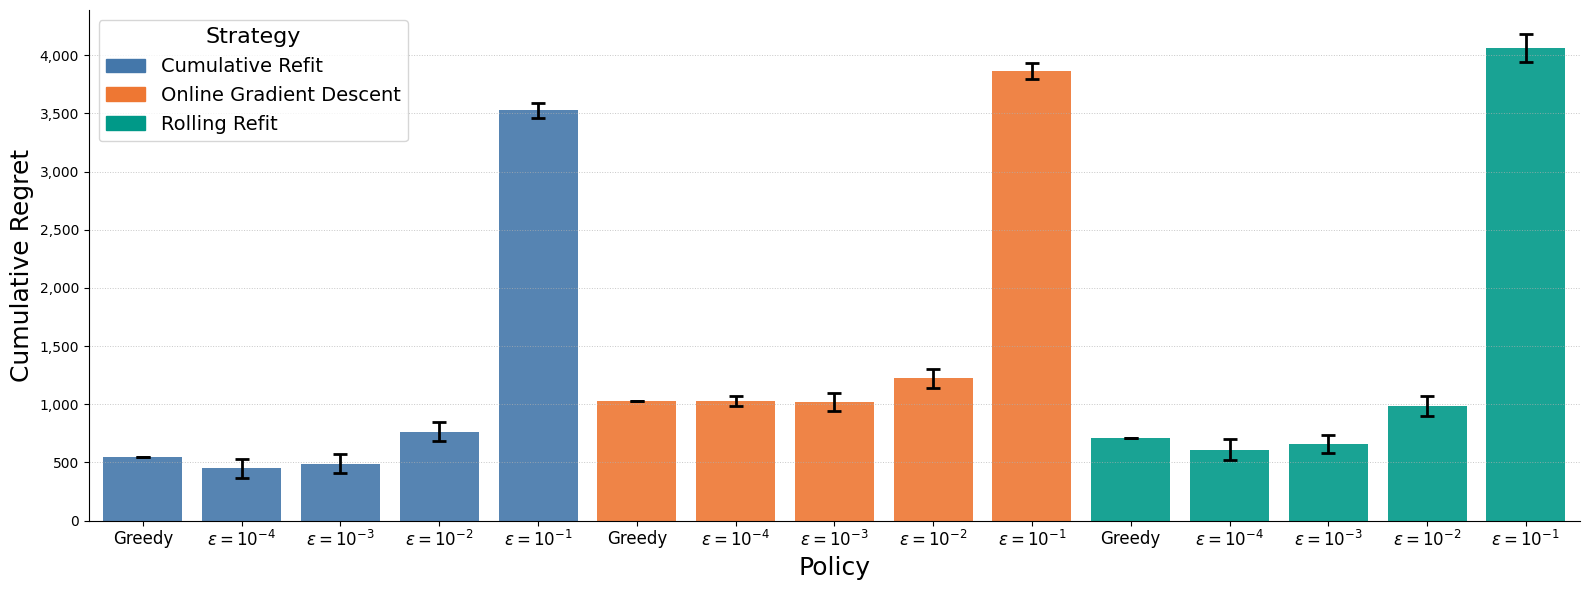

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
summary_df = summary_df[summary_df["epsilon"].isin([np.nan, 0.0001,0.001,0.01,0.1])]
plot_df = summary_df.copy()
plot_df["epsilon_sort"] = plot_df["epsilon"].fillna(-1)
plot_df = plot_df.sort_values(["strategy", "epsilon_sort"], kind="mergesort")

strategy_map = {
    "cf": "Cumulative Refit",
    "ogd": "Online Gradient Descent",
    "rf": "Rolling Refit"
}
colors = {
    "cf": "#4477AA",  
    "ogd": "#EE7733",  
    "rf": "#009988",   
}

def format_eps(x):
    if pd.isna(x):
        return "Greedy"
    exp = int(f"{float(x):.0e}".split("e")[1])
    return rf"$\epsilon=10^{{{exp}}}$"

plot_df["epsilon_label"] = plot_df["epsilon"].apply(format_eps)
fig, ax = plt.subplots(figsize=(16, 6))

x = np.arange(len(plot_df))
bars = ax.bar(
    x,
    plot_df["mean"],
    yerr=plot_df["sd"],
    capsize=5,
    color=[colors[s] for s in plot_df["strategy"]],
    label=None,
    alpha=0.90,                                                         
    error_kw=dict(                            
        ecolor="black",
        elinewidth=2,
        capthick=2,
        zorder=3
    ),
)

ax.set_ylabel("Cumulative Regret", fontsize=18)   
ax.set_xlabel("Policy", fontsize=18)                   


ax.set_xticks(x)
ax.set_xticklabels(
    plot_df["epsilon_label"],
    rotation=0,          
    ha="center",
    fontsize=12           
)


ax.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{int(v):,}"))


ax.grid(axis="y", linestyle=":", linewidth=0.7, alpha=0.7)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.margins(x=0.01)


handles = [plt.Rectangle((0,0),1,1,color=colors[s]) for s in strategy_map]
labels = [strategy_map[s] for s in strategy_map]
ax.legend(handles, labels, title="Strategy", fontsize=14, title_fontsize=16)

plt.tight_layout()
plt.savefig("bar.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Grid plot

/var/tmp/pbs.898248.pbs-7/ipykernel_19996/2958917952.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  eps_colors = {e: cm.get_cmap("Set1", len(eps_list))(i) for i, e in enumerate(eps_list)}


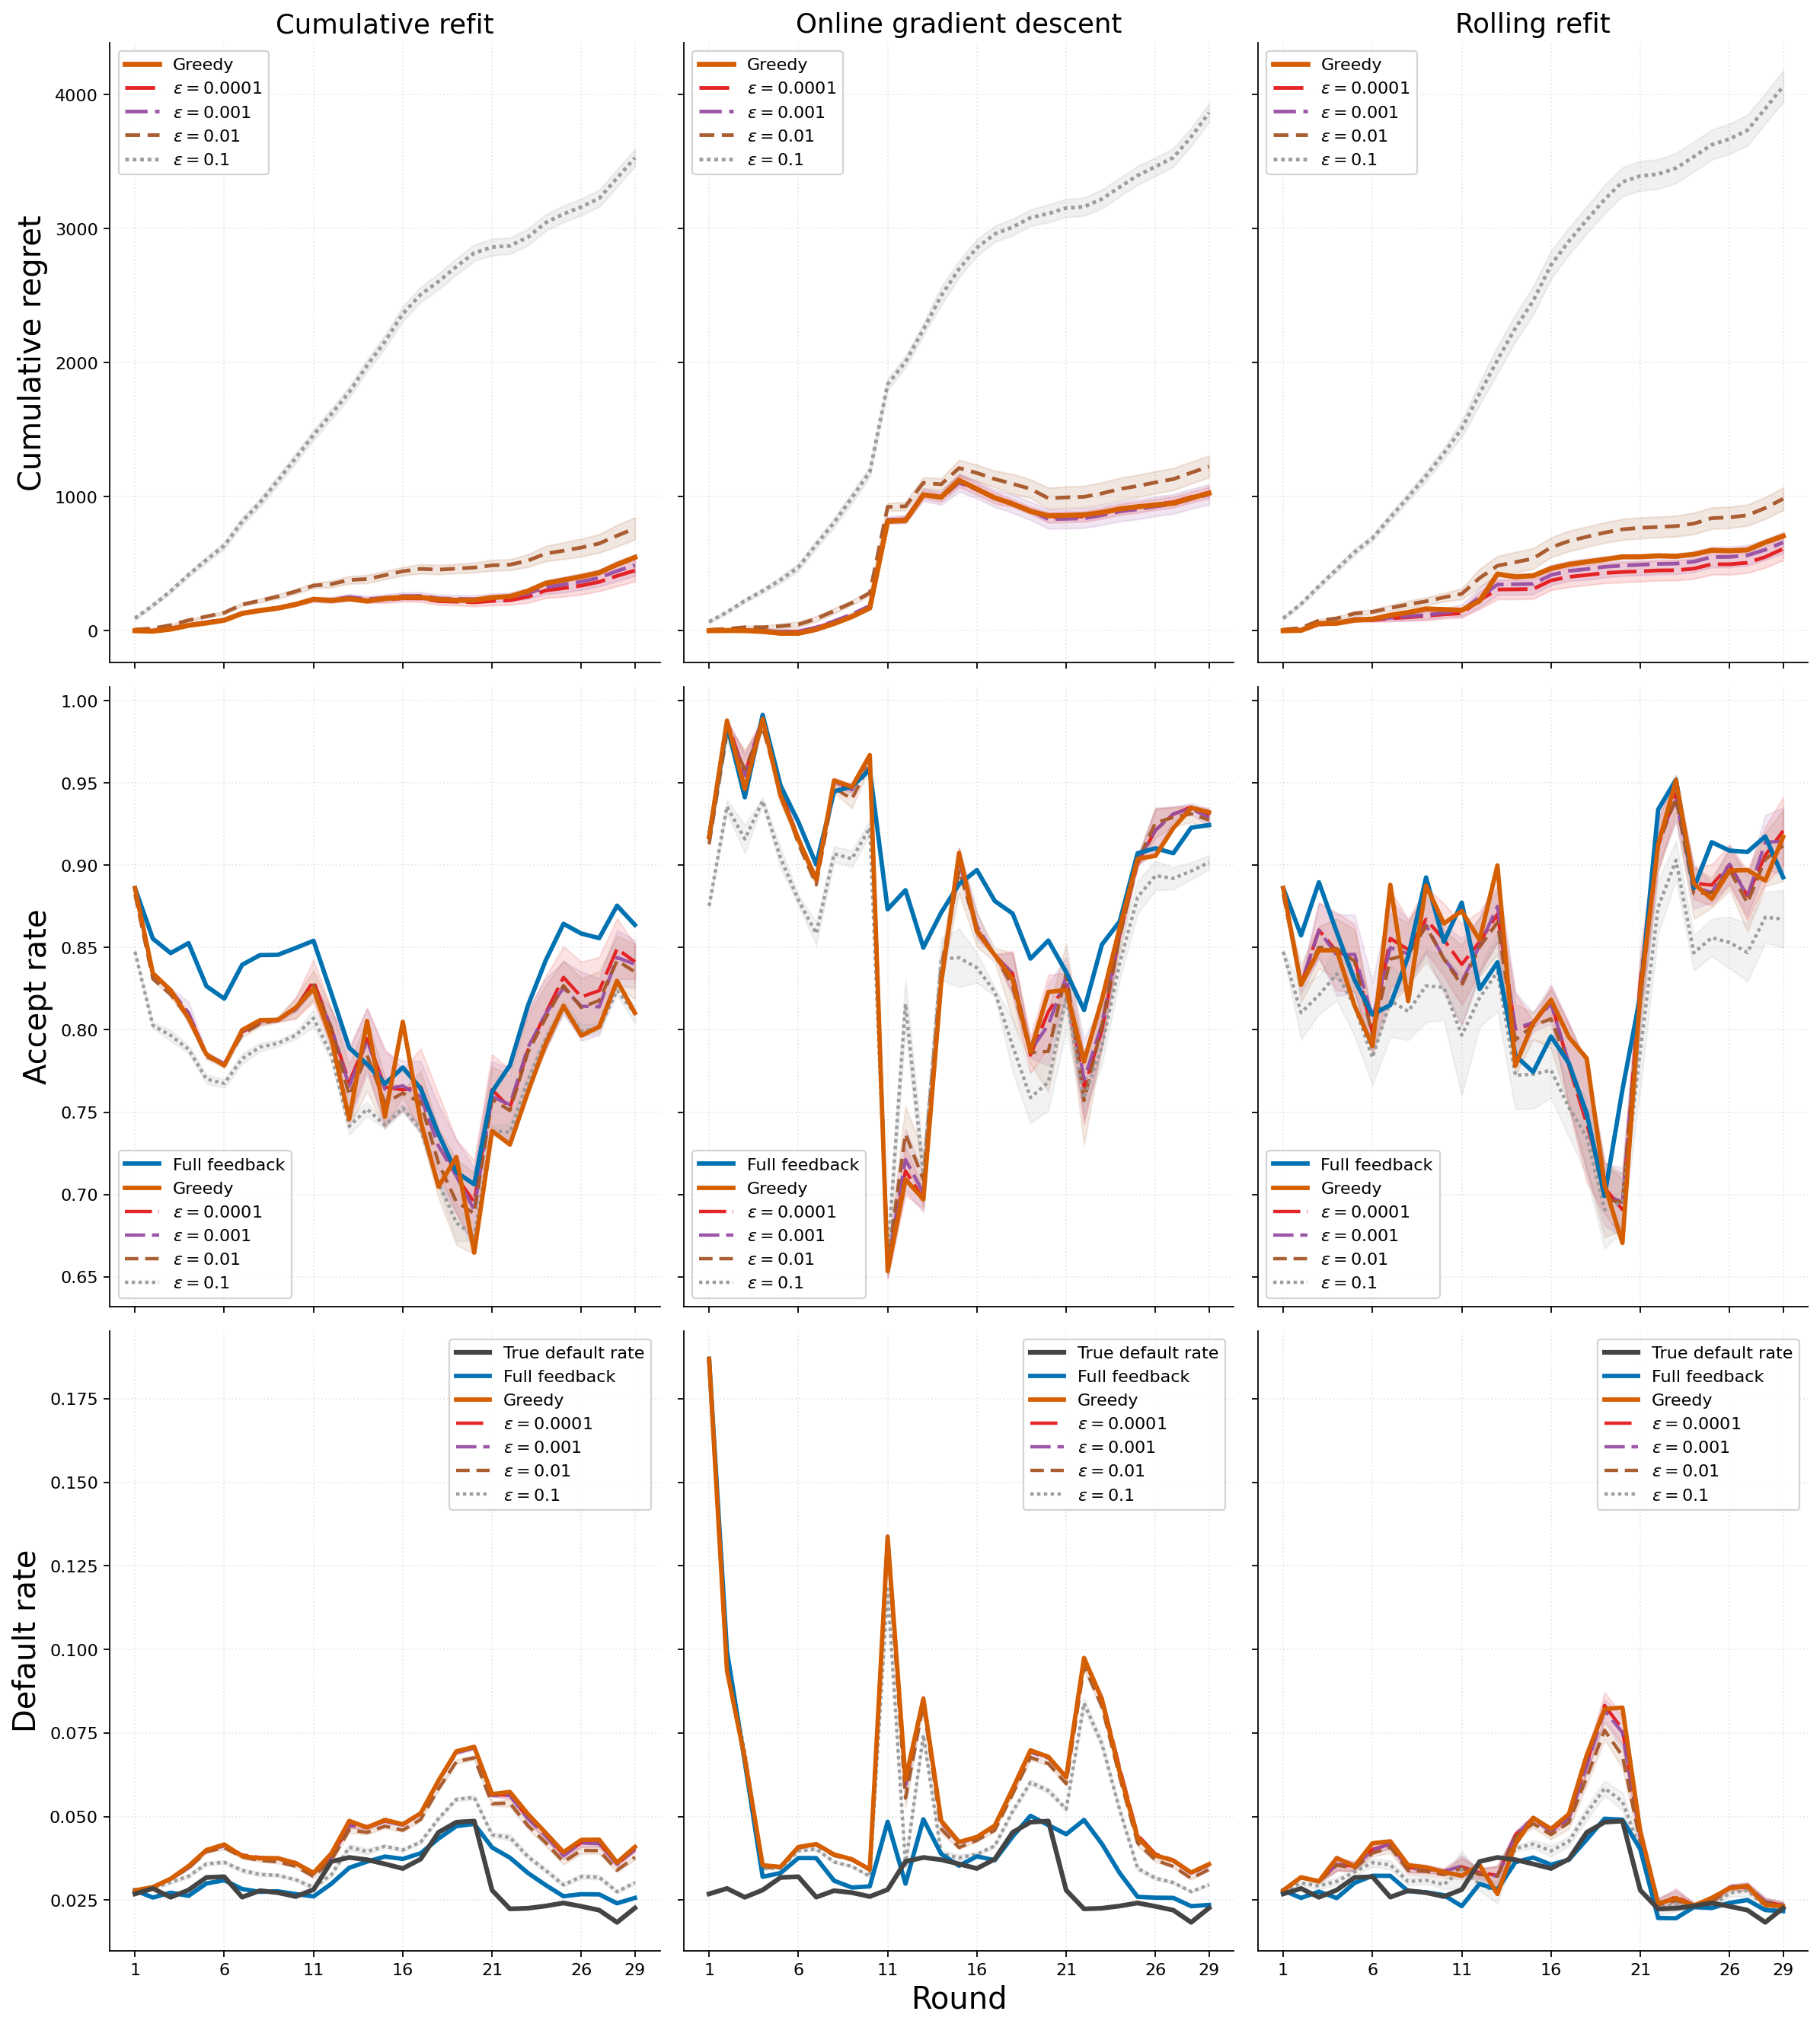

In [50]:
import os, glob
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm


base = "/rds/general/user/ms2524/home/MSc-project/notebooks/666"
methods = ["cf", "ogd", "rf"]
eps_list = ["0.0001", "0.001", "0.01", "0.1"]
key = "segment_num"

plt.rcParams.update({
    "figure.dpi": 160, "axes.titlesize": 16, "axes.labelsize": 13,
    "legend.fontsize": 10, "lines.linewidth": 2.0,
})

colors = {"full feedback": "#0072B2", "greedy": "#D55E00", "true": "#444444"}
eps_colors = {e: cm.get_cmap("Set1", len(eps_list))(i) for i, e in enumerate(eps_list)}
dashes = {"0.0001": (8,2), "0.001": (6,2), "0.01": (4,2), "0.1": (1,1)}
titles = {"cf": "Cumulative refit", "ogd": "Online gradient descent", "rf": "Rolling refit"}

def read_series(path, col):
    return pd.read_csv(path).set_index(key)[col].sort_index()

def mean_sd(pattern, col):
    series = [read_series(f, col) for f in glob.glob(pattern)]
    mat = pd.concat(series, axis=1)
    return mat.mean(axis=1), mat.std(axis=1, ddof=0)

def oracle_mean_utility(method):
    return mean_sd(os.path.join(base, f"{method}_oracle_seed*.csv"), "utility")[0]

def regret_mean_sd(method, pattern):
    base_u = oracle_mean_utility(method)
    regs = []
    for f in glob.glob(pattern):
        u = read_series(f, "utility")
        regs.append((base_u.reindex(u.index) - u).cumsum())
    mat = pd.concat(regs, axis=1)
    return mat.mean(axis=1), mat.std(axis=1, ddof=0)

def plot_band(ax, m, s, label, color, lw=2.2, alpha=1.0, z=5):
    ax.plot(m.index, m.values, label=label, color=color, lw=lw, alpha=alpha, zorder=z)
    ax.fill_between(m.index, (m-s).values, (m+s).values, color=color, alpha=0.18*alpha, zorder=z-1)

fig, axes = plt.subplots(3, 3, figsize=(16, 18), sharex=True, sharey='row')

for c, method in enumerate(methods):
    # row 1: cumulative regret vs oracle
    ax = axes[0, c]
    ax.set_title(titles[method])
    m, s = regret_mean_sd(method, os.path.join(base, f"{method}_bandit_seed*.csv"))
    plot_band(ax, m, s, "Greedy", colors["greedy"], lw=3.0, z=6)
    for e in eps_list:
        m, s = regret_mean_sd(method, os.path.join(base, f"{method}_epsilon_greedy_eps{e}_seed*.csv"))
        line = ax.plot(m.index, m.values, color=eps_colors[e], lw=2.2, alpha=0.95, label=rf"$\epsilon={e}$", zorder=5)[0]
        line.set_dashes(dashes[e])
        ax.fill_between(m.index, (m-s).values, (m+s).values, color=eps_colors[e], alpha=0.14, zorder=4)
    ax.grid(True, alpha=0.3, linestyle=":"); ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
    ax.legend(loc="upper left", frameon=True, fancybox=True, framealpha=0.85)

    # row 2: accept rate
    ax = axes[1, c]
    for variant, lab in [("oracle","Full feedback"), ("bandit","Greedy")]:
        m, s = mean_sd(os.path.join(base, f"{method}_{variant}_seed*.csv"), "accept_rate")
        plot_band(ax, m, s, lab, colors[lab.lower()], lw=2.6, z=6)
    for e in eps_list:
        m, s = mean_sd(os.path.join(base, f"{method}_epsilon_greedy_eps{e}_seed*.csv"), "accept_rate")
        line = ax.plot(m.index, m.values, color=eps_colors[e], lw=2.0, alpha=0.95, label=rf"$\epsilon={e}$", zorder=5)[0]
        line.set_dashes(dashes[e])
        ax.fill_between(m.index, (m-s).values, (m+s).values, color=eps_colors[e], alpha=0.12, zorder=4)
    ax.grid(True, alpha=0.3, linestyle=":"); ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
    ax.legend(loc="lower left", frameon=True, fancybox=True, framealpha=0.85)

    # row 3: default rates
    ax = axes[2, c]
    true = read_series(glob.glob(os.path.join(base, f"{method}_oracle_seed*.csv"))[0], "actual_default_rate")
    ax.plot(true.index, true.values, label="True default rate", lw=2.8, color=colors["true"], zorder=7)
    for variant, lab in [("oracle","Full feedback"), ("bandit","Greedy")]:
        m, s = mean_sd(os.path.join(base, f"{method}_{variant}_seed*.csv"), "predicted_default_rate")
        plot_band(ax, m, s, lab, colors[lab.lower()], lw=2.6, z=6)
    for e in eps_list:
        m, s = mean_sd(os.path.join(base, f"{method}_epsilon_greedy_eps{e}_seed*.csv"), "predicted_default_rate")
        line = ax.plot(m.index, m.values, color=eps_colors[e], lw=2.0, alpha=0.95, label=rf"$\epsilon={e}$", zorder=5)[0]
        line.set_dashes(dashes[e])
        ax.fill_between(m.index, (m-s).values, (m+s).values, color=eps_colors[e], alpha=0.12, zorder=4)
    ax.grid(True, alpha=0.3, linestyle=":"); ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
    ax.legend(loc="upper right", frameon=True, fancybox=True, framealpha=0.85)

# labels
axes[0,0].set_ylabel("Cumulative regret", fontsize=18)
axes[1,0].set_ylabel("Accept rate", fontsize=18)
axes[2,0].set_ylabel("Default rate", fontsize=18)
axes[-1,1].set_xlabel("Round", fontsize=18)

# tidy axes
for c in range(1, len(methods)):
    for r in range(3):
        axes[r, c].tick_params(labelleft=False)
for ax in axes.ravel():
    ax.set_xticks([1, 6, 11, 16, 21, 26, 29])

plt.tight_layout(rect=[0.06, 0.05, 1.00, 0.98])
plt.savefig("grid.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Reward optimisation

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from joblib import Parallel, delayed
from functools import partial

def make_utility(fn_weight, tn_weight):
    def utility(tn, fn):
        return fn_weight * fn + tn_weight * tn
    return utility

def find_best_threshold(y_true, y_proba, thresholds, utility_fn):
    best_util = -np.inf
    best_threshold = None
    for th in thresholds:
        accept = y_proba < th
        tn = np.sum((accept) & (y_true == 0))
        fn = np.sum((accept) & (y_true == 1))
        util = utility_fn(tn, fn)
        if util > best_util:
            best_util = util
            best_threshold = th
    return best_threshold, best_util

def evaluate_segment(
    test_key,
    final_segments,
    features,
    x_values,
    thresholds,
    random_state,
    window_size
):
    results = []

    sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[-1]))
    test_idx = sorted_keys.index(test_key)
    start_idx = max(0, test_idx - window_size)
    prev_keys = sorted_keys[start_idx:test_idx]

    X_train_list = [final_segments[key][features] for key in prev_keys]
    y_train_list = [final_segments[key]['target'].astype(int) for key in prev_keys]

    X_train = pd.concat(X_train_list, axis=0)
    y_train = pd.concat(y_train_list, axis=0)

    X_test = final_segments[test_key][features]
    y_test = final_segments[test_key]['target'].astype(int)

    X_train, X_test = impute_features(X_train, X_test, features_with_missing)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = LogisticRegression(random_state=random_state, max_iter=1000, penalty=None)
    model.fit(X_train_scaled, y_train)

    ytrain_proba = model.predict_proba(X_train_scaled)[:, 1]
    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    y_pred_fool = np.zeros_like(y_test)
    tn_f, fp_f, fn_f, tp_f = confusion_matrix(y_test, y_pred_fool).ravel()

    for x in x_values:
        utility_fn = make_utility(fn_weight=-1, tn_weight=x)

        results.append({
            "x": x, "segment": test_key, "mode": "fool",
            "threshold": None,
            "utility": utility_fn(tn_f, fn_f),
            "tp": tp_f, "tn": tn_f, "fp": fp_f, "fn": fn_f,
            "accept_rate": 1.0
        })

        th_model, _ = find_best_threshold(y_train, ytrain_proba, thresholds, utility_fn)
        pred_model = (y_proba >= th_model).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, pred_model).ravel()

        results.append({
            "x": x, "segment": test_key, "mode": "Logistic Regression",
            "threshold": th_model,
            "utility": utility_fn(tn, fn),
            "tp": tp, "tn": tn, "fp": fp, "fn": fn,
            "accept_rate": (pred_model == 0).mean()
        })

    return results

def evaluate(
    final_segments,
    x_values,
    thresholds=np.linspace(0.01, 0.5, 40),
    random_state=42,
    n_jobs=1,
    window_size=1
):
    sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[-1]))
    features = [col for col in final_segments['split_0'].columns if col not in {'case_id', 'WEEK_NUM', 'target'}]
    test_keys = sorted_keys[1:]

    evaluate_fn = partial(
        evaluate_segment,
        final_segments=final_segments,
        features=features,
        x_values=x_values,
        thresholds=thresholds,
        random_state=random_state,
        window_size=window_size
    )

    all_results = Parallel(n_jobs=n_jobs, verbose=10, backend="threading")(
        delayed(evaluate_fn)(test_key) for test_key in test_keys
    )

    return pd.DataFrame([row for segment in all_results for row in segment])


def run_ogd(
    final_segments,
    x_values=np.logspace(-2, np.log10(0.2), 40),
    thresholds=np.linspace(0.01, 0.5, 40),
    buffer_size=50,
    random_state=42
):
    np.random.seed(random_state)
    results = []

    exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
    features = [c for c in final_segments['split_0'].columns if c not in exclude_cols]

    scaler = StandardScaler()
    clf = SGDClassifier(
        loss='log_loss',
        max_iter=1,
        learning_rate='constant',
        eta0=0.0001,
        random_state=random_state,
        shuffle=False,
        penalty=None
    )

    buffer_X = deque(maxlen=buffer_size)
    buffer_y = deque(maxlen=buffer_size)

    segment_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[-1]))

    first_key = segment_keys[0]
    first_segment = final_segments[first_key]
    train_df = pd.DataFrame(first_segment[features].values, columns=features)
    train_filled, _ = impute_features(train_df, train_df, features_with_missing)

    X_init = train_filled.values
    y_init = first_segment['target'].values

    scaler.partial_fit(X_init)
    X_init_scaled = scaler.transform(X_init)
    clf.partial_fit(X_init_scaled, y_init, classes=[0, 1])

    buffer_X.append(first_segment[features].values)
    buffer_y.append(y_init)

    for t, seg in enumerate(segment_keys[1:], start=1):
        segment = final_segments[seg]
        y_segment = segment['target'].values

        X_buffer = np.vstack(buffer_X)
        y_buffer = np.concatenate(buffer_y)
        buffer_df = pd.DataFrame(X_buffer, columns=features)

        past_keys = segment_keys[:t]
        reference_data = pd.concat([final_segments[k][features] for k in past_keys], ignore_index=True)

        ref_filled, _ = impute_features(reference_data, reference_data, features_with_missing)
        _, buffer_filled = impute_features(reference_data, buffer_df, features_with_missing)
        X_buffer_filled = buffer_filled.values

        test_df = segment[features]
        _, test_filled = impute_features(reference_data, test_df, features_with_missing)
        X_test_filled = test_filled.values

        X_buffer_scaled = scaler.transform(X_buffer_filled)
        buffer_scores = clf.predict_proba(X_buffer_scaled)[:, 1]

        X_test_scaled = scaler.transform(X_test_filled)
        test_scores = clf.predict_proba(X_test_scaled)[:, 1]

        for x in x_values:
            utility_fn = make_utility(fn_weight=-1, tn_weight=x)

            best_threshold, _ = find_best_threshold(y_buffer, buffer_scores, thresholds, utility_fn)

            accept_decisions = test_scores < best_threshold
            accepted = np.asarray(accept_decisions, dtype=bool)
            tn = np.sum(accepted & (y_segment == 0))
            fn = np.sum(accepted & (y_segment == 1))
            util = utility_fn(tn, fn)

            results.append({
                "x": x,
                "segment": seg,
                "mode": "model",
                "threshold": best_threshold,
                "utility": util,
                "accept_rate": accepted.mean(),
                "true_default_rate": y_segment.mean(),
                "pred_default_rate": test_scores.mean(),
                "pred_default_se": test_scores.std(ddof=1) / np.sqrt(len(test_scores))
            })

            tn_f = np.sum(y_segment == 0)
            fn_f = np.sum(y_segment == 1)
            util_fool = utility_fn(tn_f, fn_f)

            results.append({
                "x": x,
                "segment": seg,
                "mode": "fool",
                "threshold": None,
                "utility": util_fool,
                "accept_rate": 1.0,
                "true_default_rate": y_segment.mean(),
                "pred_default_rate": test_scores.mean(),
                "pred_default_se": test_scores.std(ddof=1) / np.sqrt(len(test_scores))
            })

        scaler.partial_fit(X_test_filled)
        X_test_scaled_new = scaler.transform(X_test_filled)
        clf.partial_fit(X_test_scaled_new, y_segment)

        buffer_X.append(segment[features].values)
        buffer_y.append(y_segment)

    return pd.DataFrame(results)


In [ ]:
x_values =np.logspace(-2,np.log10(0.2),40) 
final_segments = split_by_week(df, 30)
results_df1 = evaluate(
    final_segments,
    x_values,
    thresholds=np.linspace(0.01, 0.5, 40),
    random_state=42,
    n_jobs=2,                  
    window_size=1)
results_df2 = evaluate(
    final_segments,
    x_values,
    thresholds=np.linspace(0.01, 0.5, 40),
    random_state=42,
    n_jobs=2,                  
    window_size=100)
results_df3 = run_ogd(final_segments)

# Learning rate optimisation

In [ ]:
def tune(
    final_segments,
    eta0_values=[0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005],
    test_size=0.3,
    random_state=42
):
    from sklearn.linear_model import SGDClassifier
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import average_precision_score

    split_0 = final_segments['split_0']
    exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
    features = [col for col in split_0.columns if col not in exclude_cols]

    X_raw = split_0[features].values
    y = split_0['target'].values

    X_train_raw, X_val_raw, y_train, y_val = train_test_split(
        X_raw, y, test_size=test_size, stratify=y, random_state=random_state
    )

    df_train = pd.DataFrame(X_train_raw, columns=features)
    df_val = pd.DataFrame(X_val_raw, columns=features)
    df_train_imputed, df_val_imputed = impute_features(df_train, df_val, features_with_missing)

    X_train = df_train_imputed.values
    X_val = df_val_imputed.values

    scaler = StandardScaler()
    scaler.partial_fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    rows = []
    for eta in eta0_values:
        clf = SGDClassifier(
            loss='log_loss',
            learning_rate='constant',
            eta0=eta,
            shuffle=False,
            penalty=None
        )
        clf.partial_fit(X_train_scaled, y_train, classes=np.array([0, 1]))
        y_proba = clf.predict_proba(X_val_scaled)[:, 1]
        score = average_precision_score(y_val, y_proba)
        rows.append({"eta0": eta, "avg_precision": score})

    return pd.DataFrame(rows).sort_values("avg_precision", ascending=False).reset_index(drop=True)
results = tune_eta0_online_batch(final_segments)